# NLSY (Gradient Boosting)

## Load Libraries and Data

In [1]:
import io
import requests
import warnings
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, classification_report, 
                             mean_squared_error, r2_score)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRegressor
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

# Make this notebook's output stable across runs
random_state = 1000
np.random.seed(random_state)

# Options for plots
%matplotlib inline
sns.set()
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.labelpad'] = 12

In [2]:
def plot_decision_boundary(
    clf, X, y, classes, features, xlims,
    markers=['<', 'o', 's'],
    markercolors=['darkgreen', 'navy', 'darkred'],
    fillcolors=['lightgreen', 'cornflowerblue', 'lightcoral'],
    steps=1000, alpha=0.2, figsize=(15, 6)
):
    x1, x2 = np.meshgrid (np.linspace(*xlims[0], steps).reshape(-1, 1),
                          np.linspace(*xlims[1], steps).reshape(-1, 1))
    
    X_bound = np.c_[x1.ravel(), x2.ravel()]
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        y_pred = clf.predict(X_bound)
        
    z = LabelEncoder().fit_transform(y_pred).reshape(x1.shape)
    
    plt.figure(figsize=figsize)
    
    for i, c in enumerate(classes):
        plt.plot(X.loc[y == c, features[0]], X.loc[y == c, features[1]],
                 color=markercolors[i], marker=markers[i],
                 linestyle='none', label=c)
    
    plt.contourf(x1, x2, z, levels=len(classes) + 1,
                 alpha=alpha, cmap=ListedColormap(fillcolors))
   
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.legend()
    plt.show()

In [3]:
# Split data and return as dataframes
def split_data(X, y, test_size=0.2, stratify=None,
               random_state=1):
    out = train_test_split(X, y, test_size=test_size,
                           stratify=stratify,
                           random_state=random_state)
    out[0] = pd.DataFrame(out[0], columns=X.columns)
    out[1] = pd.DataFrame(out[1], columns=X.columns)

    return out

## Load Data

### Data Description

The Bureau of Labor Statistics administers a National Longitudinal Survey of Youth that tracks individuals over the course of their lives.

The 1979 (NLSY79) cohort includes men and women born in the USA between 1957 and 1964.

In the data set, each row represents an individual that participates in the 1979 cohort.

| Attribute      | Definition                                                                                   |
| -------------- | -------------------------------------------------------------------------------------------- |
| ID             | Participant identifier assigned by BLS                                                       |
| Earnings       | Annual wage earnings 2014                                                                    |
| WeeksWorked    | Count of weeks worked in 2014                                                                |
| CumWeeksWorked | Cumulative weeks of work experience during study                                             |
| Education      | Years of education as of 2014                                                                |
| IQ             | Percentile on IQ test taken in 1979                                                          |
| Gender         | Participant's gender                                                                         |
| MSA            | Did the participant reside within an urban cluster or urbanized area in 2014?                |
| Library        | Did the participant, or someone in the participant's household, have a library card in 1979? |
| Esteem         | Score on the Rosenberg Self-Esteem Scale in 1979                                             |

In [4]:
url = 'https://raw.githubusercontent.com/natecraig/aiml/main/Data/nlsy.csv'
download = requests.get(url).content
df = pd.read_csv(io.StringIO(download.decode('utf-8')))
df.head()

,ID,Earnings,WeeksWorked,CumWeeksWorked,Education,IQ,Gender,MSA,Library,Esteem
0,83,0,3,553.0,10,2,Male,Yes,Yes,18
1,84,0,3,107.0,12,9,Male,Yes,Yes,20
2,87,11500,5,759.0,12,5,Male,Yes,Yes,22
3,105,20501,11,979.0,12,84,Female,Yes,Yes,19
4,178,59000,46,1010.0,16,99,Male,No,Yes,24


In [5]:
# Return index of education category as a function of years of education
def education_category(years_education):
    if years_education < 16:
        return 'High School'
    elif years_education == 16:
        return 'Undergraduate'
    else:
        return 'Graduate'


# Create a variable to contain each participant's education category    
df['EducationCategory'] = df['Education'].apply(education_category)
df['EducationCategory'].value_counts(normalize=True)

High School      0.830679
Undergraduate    0.113160
Graduate         0.056161
Name: EducationCategory, dtype: float64

In [6]:
# Predict EducationCategory as a function of Earnings and WeeksWorked
X = df[['Earnings', 'WeeksWorked']]
y = df['EducationCategory']

# Split data into training and testing sets
(X_train, X_test, 
 y_train, y_test) = split_data(X, y, test_size=0.25,
                               stratify=y,
                               random_state=random_state)

## AdaBoost

In [7]:
# Predict EducationCategory as a function of Earnings and WeeksWorked
feature_vars = ['Earnings', 'WeeksWorked']
X = df[feature_vars]
y = df['EducationCategory']

# Split data into training and testing sets
(X_train, X_test, 
 y_train, y_test) = split_data(X, y, test_size=0.25,
                               stratify=y,
                               random_state=random_state)

In [8]:
# Fit AdaBoost classifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=6),
    n_estimators=400,
    random_state=random_state
)
ada_clf.fit(X_train, y_train)

# Evaluate on the test data
y_pred = ada_clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

               precision    recall  f1-score   support

     Graduate      0.700     0.412     0.519        17
  High School      0.956     0.960     0.958       248
Undergraduate      0.525     0.618     0.568        34

     accuracy                          0.890       299
    macro avg      0.727     0.663     0.681       299
 weighted avg      0.892     0.890     0.888       299



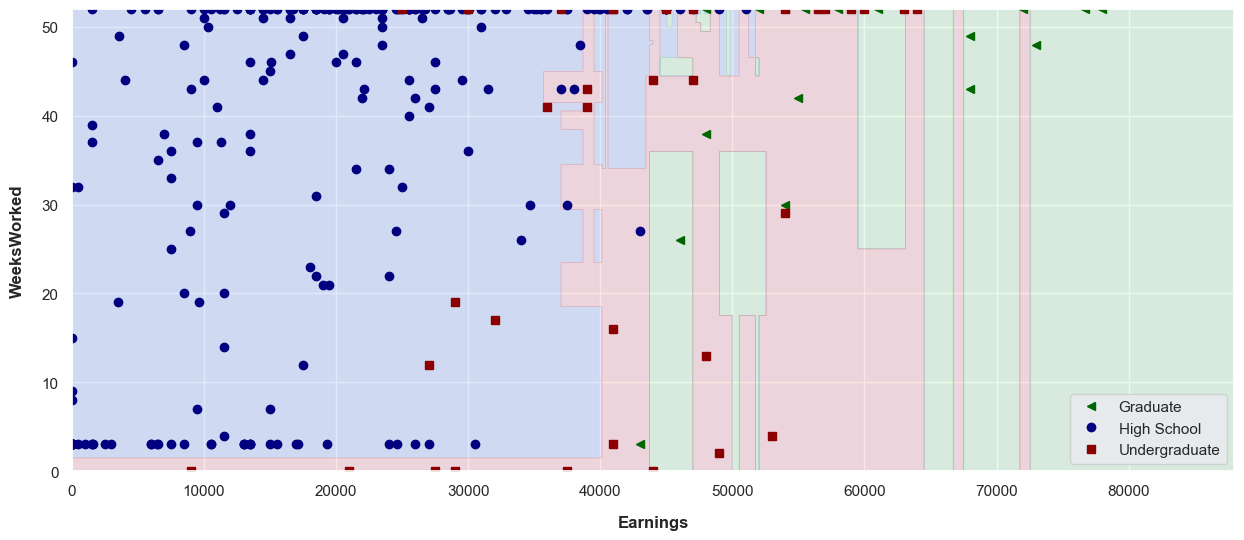

In [9]:
# Visualize decision boundaries
xlims = [
    [df['Earnings'].min(), df['Earnings'].max()],
    [df['WeeksWorked'].min(), df['WeeksWorked'].max()]
]

plot_decision_boundary(ada_clf, X_test, y_test,
                       classes=['Graduate', 'High School', 'Undergraduate'],
                       features=feature_vars,
                       xlims=xlims)     

In [10]:
# Predict EducationCategory as a function of Earnings,
# WeeksWorked, and CumWeeksWorked
feature_vars = ['Earnings', 'WeeksWorked', 'CumWeeksWorked']
X = df[feature_vars]
y = df['EducationCategory']

# Split data into training and testing sets
(X_train, X_test, 
 y_train, y_test) = split_data(X, y, test_size=0.25,
                               stratify=y,
                               random_state=random_state)

In [11]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=8),
    n_estimators=400,
    random_state=random_state
)
ada_clf.fit(X_train, y_train)

# Evaluate on the test data
y_pred = ada_clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

               precision    recall  f1-score   support

     Graduate      0.875     0.824     0.848        17
  High School      0.957     0.976     0.966       248
Undergraduate      0.700     0.618     0.656        34

     accuracy                          0.926       299
    macro avg      0.844     0.806     0.824       299
 weighted avg      0.923     0.926     0.924       299



### Exercise

Experiment with the AdaBoost learning rate (learning_rate) using cross-validation.

## Gradient Boosting

In [12]:
# Predict EducationCategory as a function of Earnings and WeeksWorked
feature_vars = ['Earnings', 'WeeksWorked']
X = df[feature_vars]
y = df['EducationCategory']

# Split data into training and testing sets
(X_train, X_test, 
 y_train, y_test) = split_data(X, y, test_size=0.25,
                               stratify=y,                               
                               random_state=random_state)

In [13]:
# Fit Gradient Boosting classifier
grb_clf = GradientBoostingClassifier(random_state=random_state)
grb_clf.fit(X_train, y_train)

# Evaluate on the test data
y_pred = grb_clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

               precision    recall  f1-score   support

     Graduate      0.667     0.353     0.462        17
  High School      0.957     0.976     0.966       248
Undergraduate      0.568     0.618     0.592        34

     accuracy                          0.900       299
    macro avg      0.730     0.649     0.673       299
 weighted avg      0.896     0.900     0.895       299



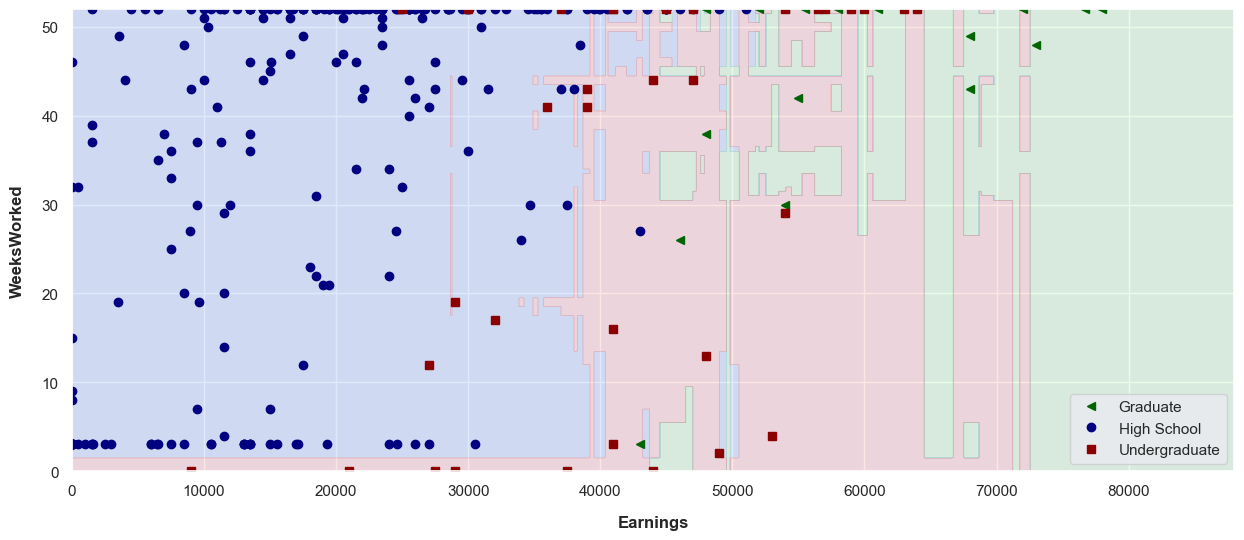

In [14]:
# Visualize decision boundaries
xlims = [
    [df['Earnings'].min(), df['Earnings'].max()],
    [df['WeeksWorked'].min(), df['WeeksWorked'].max()]
]

plot_decision_boundary(grb_clf, X_test, y_test,
                       classes=['Graduate', 'High School', 'Undergraduate'],
                       features=feature_vars,
                       xlims=xlims)     

In [15]:
# Predict EducationCategory as a function of Earnings,
# WeeksWorked, and CumWeeksWorked
feature_vars = ['Earnings', 'WeeksWorked', 'CumWeeksWorked']
X = df[feature_vars]
y = df['EducationCategory']

# Split data into training and testing sets
(X_train, X_test, 
 y_train, y_test) = train_test_split(X, y, test_size=0.25,
                                     stratify=y, random_state=random_state)

In [16]:
# Fit Gradient Boosting classifier
grb_clf = GradientBoostingClassifier(random_state=random_state)
grb_clf.fit(X_train, y_train)

# Evaluate on the test data
y_pred = grb_clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

               precision    recall  f1-score   support

     Graduate      0.667     0.706     0.686        17
  High School      0.960     0.972     0.966       248
Undergraduate      0.600     0.529     0.562        34

     accuracy                          0.906       299
    macro avg      0.742     0.736     0.738       299
 weighted avg      0.903     0.906     0.904       299



### Exercise

Build a better gradient boosting model by experimenting with cross-validation for hyperparameter optimization.

## XGBoost

In [17]:
# Predict EducationCategory as a function of Earnings,
# WeeksWorked, and CumWeeksWorked
feature_vars = ['Earnings', 'WeeksWorked', 'CumWeeksWorked']
X = df[feature_vars]
y = df['EducationCategory']

# Use label encoder on y to satisfy XGBoost
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)

# Split data into training and testing sets
(X_train, X_test, 
 y_train, y_test) = split_data(X, y_enc, test_size=0.25,
                               stratify=y,
                               random_state=random_state)

In [18]:
# Fit Gradient Boosting classifier
xgb_clf = XGBClassifier(random_state=random_state,
                        eval_metric='mlogloss')
xgb_clf.fit(X_train, y_train)

# Evaluate on the test data
y_pred = xgb_clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.778     0.824     0.800        17
           1      0.960     0.964     0.962       248
           2      0.625     0.588     0.606        34

    accuracy                          0.913       299
   macro avg      0.788     0.792     0.789       299
weighted avg      0.911     0.913     0.912       299



## XGBoost: Store Closings, Regression Example

### Data Description

When retailers close stores, they usually conduct going-out-of-business (GOB) sales.

In the data set, each row represents a store's going out of business sale.

| Attribute             | Definition                                                                |
| --------------------- | ------------------------------------------------------------------------- |
| StoreType             | Store's retail segment (bookstores or household goods)                    |
| LiquidationRevenue    | Revenue from the GOB sale                                                 |
| InventoryAtTicket     | Retail value of inventory held at the start of the GOB sale               |
| LastYearRevenue       | Store's revenue over the GOB sale dates during the prior year             |                      
| MedianHouseholdIncome | Median household income in the store's ZIP code (from U.S. Census Bureau) |
| MedianAge             | Median age in the store's ZIP code (from U.S. Census Bureau)              |

In [19]:
url = 'https://raw.githubusercontent.com/natecraig/aiml/main/Data/closings.csv'
download = requests.get(url).content
df = pd.read_csv(io.StringIO(download.decode('utf-8')))
df.head()

,StoreType,LiquidationRevenue,InventoryAtTicket,LastYearRevenue,MedianHouseholdIncome,MedianAge
0,Bookstore,1214776.2,2195069.8,465237.3,51290,37.8
1,Bookstore,1811896.9,3152301.9,897704.5,46702,33.4
2,Bookstore,1157614.7,2229837.5,477804.8,86804,41.7
3,Bookstore,2037136.2,3857466.8,1036097.7,83544,40.3
4,Bookstore,1326821.1,2345263.8,612793.5,23508,31.9


In [20]:
# Predict LiquidationRevenue as a function of all available variables
df['Bookstore'] = df['StoreType'].map(lambda x: 1 if x == 'Bookstore' else 0)
feature_vars = ['Bookstore', 'InventoryAtTicket', 'LastYearRevenue',
                'MedianHouseholdIncome', 'MedianAge']
X = df[feature_vars]
y = df['LiquidationRevenue']

# Split data into training and testing sets
(X_train, X_test, 
 y_train, y_test) = train_test_split(X, y, test_size=0.2,
                                     stratify=df['StoreType'],
                                     random_state=random_state)

In [21]:
# Use cross-validation to optimize the learning rate
search_parameters = {
    'learning_rate':np.arange(0.05, 0.15, 0.01),
    'max_depth':[2, 4, 6, 8]
}

xgb_reg = XGBRegressor(random_state=random_state)
grid_reg = GridSearchCV(xgb_reg, search_parameters)
grid_reg.fit(X_train, y_train)

print(f'Best learning rate: {grid_reg.best_params_["learning_rate"]:.3f}')
print(f'Best max depth: {grid_reg.best_params_["max_depth"]:.3f}')

Best learning rate: 0.110
Best max depth: 2.000


In [22]:
# Get the best-performing classifier
best_xgb_reg = grid_reg.best_estimator_

# Calculate performance on test data
y_pred = best_xgb_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Test MSE:   {mse:.3f}\n'
      f'Test RMSE:  {rmse:.3f}\n'
      f'Test R2:    {r2_score(y_test, y_pred):.3f}')

Test MSE:   35209345033.568
Test RMSE:  187641.533
Test R2:    0.927
